<a href="https://colab.research.google.com/github/mitsouma/Deep-Learning_Labs/blob/main/Practical_Convolutional_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practical 2: Convolutional Networks


## Introduction
In this practical we will cover the basics of convolutional neural networks, or "ConvNets". ConvNets were invented in the late 1980s/early 1990s, and have had tremendous success especially with vision (although they have also been used very successfully in speech processing pipelines, and more recently, for machine translation).

## Learning Objectives
* Be able to explain what a convolutional layer does and how it's different from a fully-connected layer
* Understand  the assumptions and trade-offs that are being made when using convolutional architectures
* Be able to build a convolutional architecture using Tensorflow and Keras Layers
* Be able to use Keras to train a model on a dataset
* Implement either batch normalisation or a very small residual network

## Running on GPU
For this practical, you will need to use a GPU to speed up training. To do this, go to the "Runtime" menu in Colab, select "Change runtime type" and then in the popup menu, choose "GPU" in the "Hardware accelelator" box. This is all you need to do, Colab and Tensorflow will take care of the rest!

In [ ]:
#@title Imports (RUN ME!) { display-mode: "form" }

# TODO: Swallow output
!pip -q install pydot_ng
!pip -q install graphviz
!apt install graphviz > /dev/null

from __future__ import absolute_import, division, print_function

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline



## The CIFAR10 Dataset
Now that we understand convolutional, max-pooling and feed-forward layers, we can combine these as building block to build a ConvNet classifier for images. For this practical, we will use the colour image dataset CIFAR10 (pronounced "seefar ten") which consists of 50,000 training images and 10,000 test images. As we did in Practical 1, we take 10,000 images from the training set to form a validation set and visualise some example images.

In [ ]:
cifar = tf.keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar.load_data()
cifar_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
# Take the last 10000 images from the training set to form a validation set

a = np.zeros((300, 200, 1))
print (a.shape)

a = a.squeeze()

print (a.shape)

train_labels = train_labels.squeeze()
validation_images = train_images[-10000:, :, :]
validation_labels = train_labels[-10000:]
train_images = train_images[:-10000, :, :]
train_labels = train_labels[:-10000]

(300, 200, 1)
(300, 200)


What are the shapes and data-types of train_images and train_labels?

In [ ]:
print('train_images.shape = {}, data-type = {}'.format(train_images.shape, train_images.dtype))
print('train_labels.shape = {}, data-type = {}'.format(train_labels.shape, train_labels.dtype))

print('validation_images.shape = {}, data-type = {}'.format(validation_images.shape, validation_images.dtype))
print('validation_labels.shape = {}, data-type = {}'.format(validation_labels.shape, validation_labels.dtype))

train_images.shape = (40000, 32, 32, 3), data-type = uint8
train_labels.shape = (40000,), data-type = uint8
validation_images.shape = (10000, 32, 32, 3), data-type = uint8
validation_labels.shape = (10000,), data-type = uint8


### Visualise examples from the dataset
Run the cell below multiple times to see various images. (They might look a bit blurry because we've blown up the small images.)

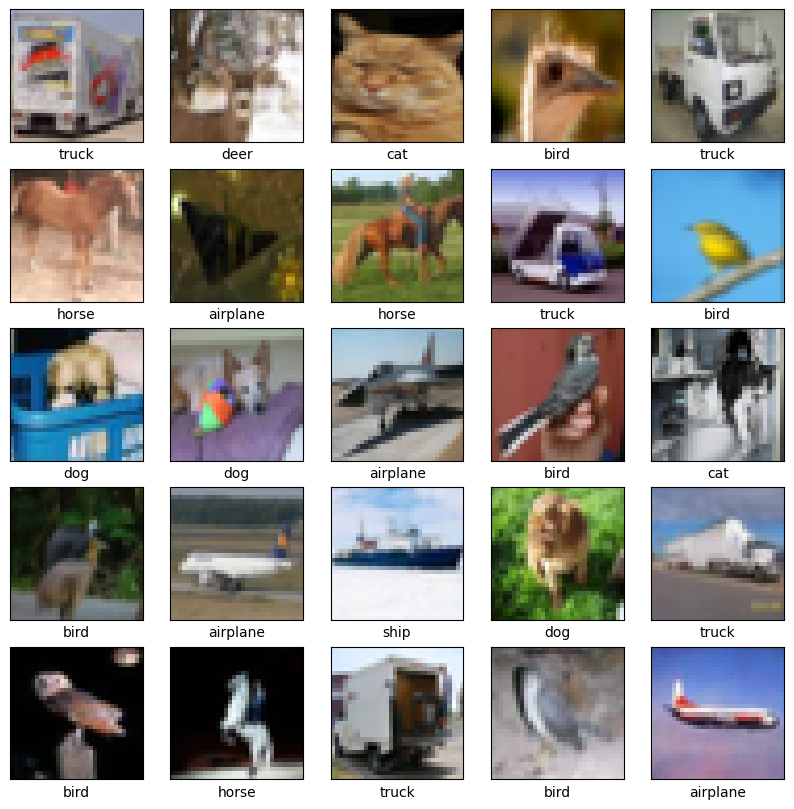

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid('off')

  img_index = np.random.randint(0, 30000)
  plt.imshow(train_images[img_index])
  plt.xlabel(cifar_labels[train_labels[img_index]])

## A ConvNet Classifier
Finally, we build a simple convolutional architecture to classify the CIFAR images. We will build a mini version of the AlexNet architecture, which consists of 5 convolutional layers with max-pooling, followed by 3 fully-connected layers at the end. In order to investigate the effect each of these two layers have on the number of parameters, we'll build the model in two stages.

First, the convolutional layers + max-pooling:

In [ ]:
# Define the convolutinal part of the model architecture using Keras Layers.
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=48, kernel_size=(3, 3), activation=tf.nn.relu, input_shape=(32, 32, 3), padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
    tf.keras.layers.Conv2D(filters=192, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.Conv2D(filters=192, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


How many parameters are there in the convolutional part of the architecture? We can easily inspect this using the model summary function in Keras:

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 48)          │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 10, 10, 48)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 10, 10, 128)         │          55,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 3, 3, 192)           │         221,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 3, 3, 192)           │         331,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 3, 3, 128)           │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 1, 1, 128)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 831,424 (3.17 MB)

 Trainable params: 831,424 (3.17 MB)

 Non-trainable params: 0 (0.00 B)

Now we add a fully-connected part. Note that we also add "Dropout" after the first fully-connected layer. Dropout is a regularization technique which randomly zeros out ("drops") connections between neurons, and it was one of the key innovations of the AlexNet paper in 2012.

In [ ]:
model.add(tf.keras.layers.Flatten())  # Flatten "squeezes" a 3-D volume down into a single vector.
model.add(tf.keras.layers.Dense(1024, activation=tf.nn.relu))
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(1024, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 48)          │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 10, 10, 48)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 10, 10, 128)         │          55,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 3, 3, 192)           │         221,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 3, 3, 192)           │         331,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 3, 3, 128)           │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         132,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,023,370 (7.72 MB)

 Trainable params: 2,023,370 (7.72 MB)

 Non-trainable params: 0 (0.00 B)

###Visualizing the model

Let's build a flow-diagram of the model we've constructed to see how information flows between the different layers.

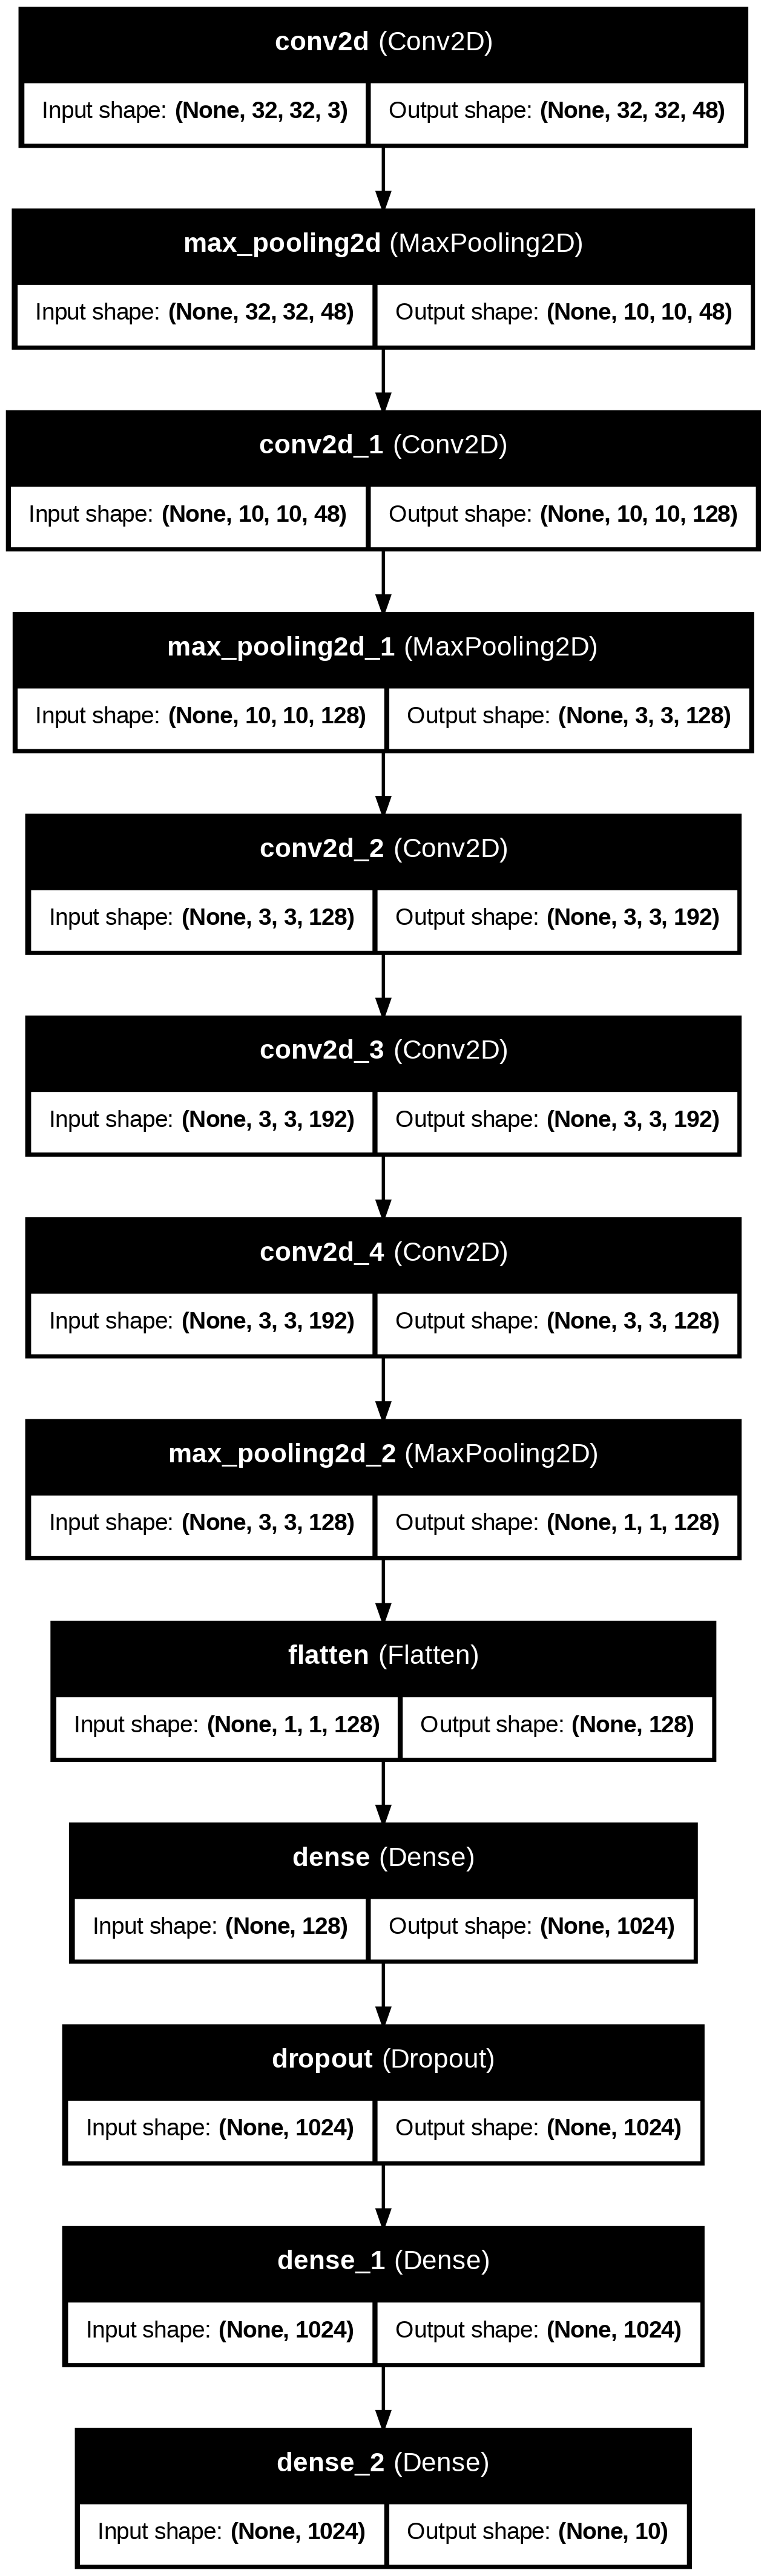

In [ ]:
tf.keras.utils.plot_model(model, to_file='small_lenet.png', show_shapes=True, show_layer_names=True)
display.display(display.Image('small_lenet.png'))


### Training and Validating the model
In the last practical we wrote out the dataset pipeline, loss function and training-loop to give you a good appreciation for how it works. This time, we use the training loop built-in to Keras. For simple, standard datasets like CIFAR, doing it this way will work fine, but it's important to know what goes on under the hood because you may need to write some or all of the steps out manually when working with more complex datasets!

In [ ]:
batch_size = 128
num_epochs = 10  # The number of epochs (full passes through the data) to train for

# Compiling the model adds a loss function, optimiser and metrics to track during training
model.compile(optimizer="Adam",
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

# The fit function allows you to fit the compiled model to some training data
model.fit(x=train_images,
          y=train_labels,
          batch_size=batch_size,
          epochs=num_epochs,
          validation_data=(validation_images, validation_labels.astype(np.float32)))

print('Training complete')

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.2804 - loss: 2.1803 - val_accuracy: 0.4966 - val_loss: 1.3773
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5388 - loss: 1.2772 - val_accuracy: 0.5917 - val_loss: 1.1467
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6214 - loss: 1.0843 - val_accuracy: 0.6200 - val_loss: 1.0877
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6709 - loss: 0.9516 - val_accuracy: 0.6437 - val_loss: 1.0221
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7041 - loss: 0.8562 - val_accuracy: 0.6522 - val_loss: 1.0276
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7251 - loss: 0.7852 - val_accuracy: 0.6732 - val_loss: 0.9551
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7587 - loss: 0.6954 - val_accuracy: 0.6831 - val_loss: 0.9414
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7760 - loss: 0.6409 - val_accuracy: 

### Test performance
Finally, we evaluate how well the model does on the held-out test-set

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6892 - loss: 1.0458


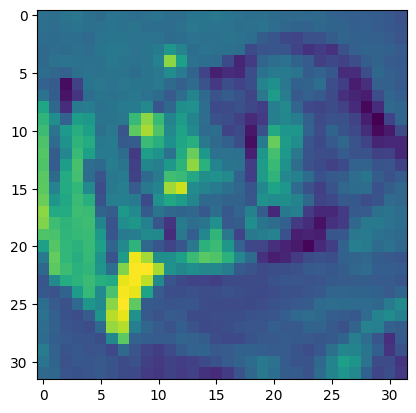

Final TEST performance
loss: 1.0568360090255737
compile_metrics: 0.6800000071525574


In [ ]:
metric_values = model.evaluate(x=test_images, y=test_labels)

print('Final TEST performance')
for metric_value, metric_name in zip(metric_values, model.metrics_names):
  print('{}: {}'.format(metric_name, metric_value))

Note that we achieved roughly 80% training set accuracy, but our test accuracy is only around 67%. What do you think may be the reason for this?

### Classifying examples
We now use our trained model to classify a sample of 25 images from the test set. We pass these 25 images to the  ```model.predict``` function, which returns a [25, 10] dimensional matrix. The entry at position $(i, j)$ of this matrix contains the probability that image $i$ belongs to class $j$. We obtain the most-likely prediction using the ```np.argmax``` function which returns the index of the maximum entry along the columns. Finally, we plot the result with the prediction and prediction probability labelled underneath the image and true label on the side.

In [ ]:
img_indices = np.random.randint(0, len(test_images), size=[25])
sample_test_images = test_images[img_indices]
sample_test_labels = [cifar_labels[i] for i in test_labels[img_indices].squeeze()]

predictions = model.predict(sample_test_images)
max_prediction = np.argmax(predictions, axis=1)
prediction_probs = np.max(predictions, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step


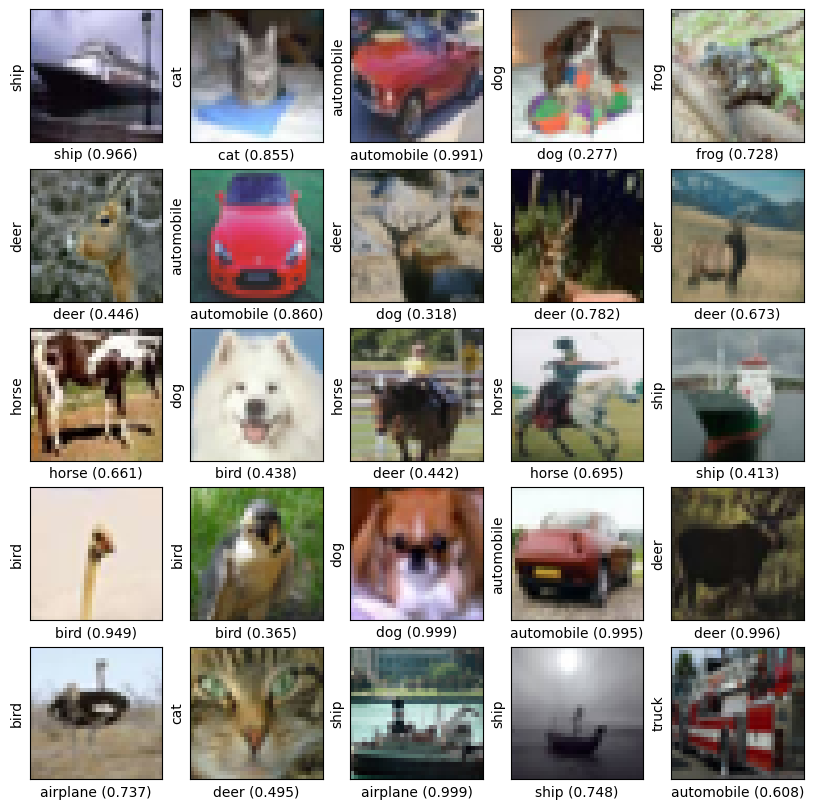

In [ ]:
plt.figure(figsize=(10,10))
for i, (img, prediction, prob, true_label) in enumerate(
    zip(sample_test_images, max_prediction, prediction_probs, sample_test_labels)):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid('off')

  plt.imshow(img)
  plt.xlabel('{} ({:0.3f})'.format(cifar_labels[prediction], prob))
  plt.ylabel('{}'.format(true_label))


### Question
What do you think of the model's predictions? Looking at the model's confidence (the probability assigned to the predicted class), look for examples of the following cases:
1. The model was correct with high confidence
2. The model was correct with low confidence
3. The model was incorrect with high confidence
4. The model was incorrect with low confidence

What do you think the (relative) loss values would be in those cases?


##Additional Resources

Here's some more information on ConvNets:

* Chris Colah's blog post on [Understanding Convolutions](https://colah.github.io/posts/2014-07-Understanding-Convolutions/)
* [How do convolutional neural networks work?](http://brohrer.github.io/how_convolutional_neural_networks_work.html)
* The [CS231n course](https://cs231n.github.io/)
* [Building blocks of interpretability](https://distill.pub/2018/building-blocks/)

